In [1]:
import pandas as pd
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Embedding, BatchNormalization, concatenate
from keras.optimizers import Adam
from keras.layers.merge import dot
from keras.models import Model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
rating_data = pd.read_csv('final_data2.csv')

In [3]:
rating_data

,Unnamed: 0,user_id,energy_consumption_perday,battery_id,rating,battery_brand,volume(kwh),Price
0,0,134,0.076942,27,3,Sonnen ECO2,0.536313,1250
1,1,42,0.059271,27,2,Sonnen ECO2,0.536313,1250
2,2,41,0.020238,27,1,Sonnen ECO2,0.536313,1250
3,3,120,0.080427,27,3,Sonnen ECO2,0.536313,1250
4,4,5,0.022503,27,1,Sonnen ECO2,0.536313,1250
...,...,...,...,...,...,...,...,...
603,603,127,0.125662,28,2,Pannasonic EverVolt1,0.184358,2220
604,604,81,0.110901,28,3,Pannasonic EverVolt1,0.184358,2220
605,605,121,0.117450,28,2,Pannasonic EverVolt1,0.184358,2220
606,606,108,0.121868,28,2,Pannasonic EverVolt1,0.184358,2220


In [4]:
rating_data['side_info_user'] = rating_data['energy_consumption_perday']

In [5]:
from sklearn.utils import shuffle
rating_data = shuffle(rating_data)

In [6]:
rating_data

,Unnamed: 0,user_id,energy_consumption_perday,battery_id,rating,battery_brand,volume(kwh),Price,side_info_user
171,171,52,0.027068,5,3,BX6.3,0.217877,1180,0.027068
247,247,48,0.339715,37,3,Redflow Zcel,0.424581,1950,0.339715
402,402,100,0.283078,18,2,BX6,0.189944,840,0.283078
514,514,131,0.122592,24,3,Pike Energy Habor5,0.810056,1136,0.122592
118,118,107,0.083672,4,5,Pulse 6,0.229050,1236,0.083672
...,...,...,...,...,...,...,...,...,...
493,493,17,0.016738,13,5,US2000B1,0.000000,718,0.016738
348,348,57,0.022108,7,3,RESU Series2,0.229050,710,0.022108
499,499,43,0.436244,13,1,US2000B1,0.000000,718,0.436244
172,172,73,0.036346,1,2,Powerwall 2,0.620112,1022,0.036346


In [7]:
rating_data['side_info_item'] = rating_data['volume(kwh)']

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
x_train, x_test, y_train, y_test = train_test_split(rating_data[['user_id','battery_id','side_info_user','side_info_item']], rating_data[['rating']], test_size=0.2, random_state=42)

In [9]:
x_train

,user_id,battery_id,side_info_user,side_info_item
200,58,20,0.000000,0.502793
413,72,18,0.039148,0.189944
9,150,27,0.089839,0.536313
129,41,23,0.020238,0.620112
606,108,28,0.121868,0.184358
...,...,...,...,...
469,130,29,0.045912,0.821229
117,34,4,0.024963,0.229050
24,70,12,0.043210,0.402235
57,102,17,0.140168,0.229050


In [10]:
num_users = 150
num_batteries = 39

In [11]:
aux_input_user = Input(shape=(1,))
aux_dense1 = Dense(128, activation='relu')(aux_input_user)
aux_dense1 = Dropout(0.3)(aux_dense1)
aux_dense_user = Dense(64, activation='relu')(aux_dense1)
aux_dense_user.shape

TensorShape([None, 64])

In [12]:
aux_input_item = Input(shape=(1,))
aux_dense1 = Dense(128, activation='relu')(aux_input_item)
aux_dense1 = Dropout(0.3)(aux_dense1)
aux_dense_item = Dense(64, activation='relu')(aux_dense1)
aux_dense_item.shape

TensorShape([None, 64])

In [13]:
latent_factors = 5

In [14]:
user_input = Input(shape=(1,),name='user_input', dtype='int32')
user_embedding = Embedding(num_users+1, latent_factors, name='user_embedding')(user_input)
user_flat = Flatten(name='user_flat')(user_embedding) #展平也可用 GlobalAveragePooling1D()
user_flat = Dropout(0.3)(user_flat)
user_dense = Dense(256, activation='relu')(user_flat)
user_dense = Dropout(0.3)(user_dense)
user_dense = Dense(128, activation='relu')(user_dense)
user_dense = Dropout(0.3)(user_dense)
user_dense = Dense(64, activation='relu')(user_dense)

In [15]:
user_dense.shape

TensorShape([None, 64])

In [16]:
concat_user = concatenate([user_dense,aux_dense_user],axis=-1)

In [17]:
concat_user.shape

TensorShape([None, 128])

In [18]:
battery_input = Input(shape=(1,),name='battery_input', dtype='int32')
battery_embedding = Embedding(num_batteries+1, latent_factors, name='battery_embedding')(battery_input)
battery_flat = Flatten(name='battery_flat')(battery_embedding)
battery_flat = Dropout(0.3)(battery_flat)
battery_dense = Dense(256, activation='relu')(battery_flat)
battery_dense = Dropout(0.3)(battery_dense)
battery_dense = Dense(128, activation='relu')(battery_dense)
battery_dense = Dropout(0.3)(user_dense)
battery_dense = Dense(64, activation='relu')(battery_dense)

In [19]:
concat_battery = concatenate([battery_dense,aux_dense_item],axis=-1)

In [20]:
product=dot([concat_user, concat_battery], name='product', axes=1)

In [21]:
dense1 = Dense(512, activation='relu')(product)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(256, activation='relu')(dense1)
dense2 = Dropout(0.3)(dense2)
dense3 = Dense(128, activation='relu')(dense2)
dense3 = Dropout(0.3)(dense3)
dense4 = Dense(64, activation='relu')(dense3)
dense_out = Dense(1, activation='relu')(dense4)

In [22]:
model = Model([user_input,aux_input_user,battery_input,aux_input_item],dense_out)

In [23]:
learning_rate = 0.00005
epochs = 120
batch_size = 256

In [24]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-3,
        patience=4,
        verbose=1)
]

In [25]:
model.compile(optimizer=Adam(lr=learning_rate), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [26]:
history = model.fit([x_train['user_id'], x_train['side_info_user'],x_train['battery_id'],x_train['side_info_item']], y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True, 
                validation_split=0.25)

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 364 samples, validate on 122 samples
Epoch 1/120
364/364 [==============================] - 0s 1ms/step - loss: 9.3692 - root_mean_squared_error: 3.0857 - mean_absolute_error: 2.7779 - val_loss: 10.5079 - val_root_mean_squared_error: 3.1073 - val_mean_absolute_error: 2.7895
Epoch 2/120
364/364 [==============================] - 0s 55us/step - loss: 9.3613 - root_mean_squared_error: 3.0838 - mean_absolute_error: 2.7707 - val_loss: 10.4972 - val_root_mean_squared_error: 3.1066 - val_mean_absolute_error: 2.7888
Epoch 3/120
364/364 [==============================] - 0s 52us/step - loss: 9.3515 - root_mean_squared_error: 3.0960 - mean_absolute_error: 2.7806 - val_loss: 10.4854 - val_root_mean_squared_error: 3.1058 - val_mean_absolute_error: 2.7879
Epoch 4/120
364/364 [==============================] - 0s 52us/step - loss: 9.3406 - root_mean_squared_error: 3.0993 - mean_absolute_error: 2.7844 - val_loss: 10.4729 - val_root_mean_squared_error: 3.1049 - val_mean_absolute_error: 2.7869

364/364 [==============================] - 0s 52us/step - loss: 8.5180 - root_mean_squared_error: 3.0569 - mean_absolute_error: 2.7337 - val_loss: 9.5608 - val_root_mean_squared_error: 3.0566 - val_mean_absolute_error: 2.7330
Epoch 36/120
364/364 [==============================] - 0s 52us/step - loss: 8.4531 - root_mean_squared_error: 3.0537 - mean_absolute_error: 2.7300 - val_loss: 9.4913 - val_root_mean_squared_error: 3.0538 - val_mean_absolute_error: 2.7297
Epoch 37/120
364/364 [==============================] - 0s 49us/step - loss: 8.3658 - root_mean_squared_error: 3.0513 - mean_absolute_error: 2.7270 - val_loss: 9.4160 - val_root_mean_squared_error: 3.0507 - val_mean_absolute_error: 2.7262
Epoch 38/120
364/364 [==============================] - 0s 47us/step - loss: 8.3239 - root_mean_squared_error: 3.0479 - mean_absolute_error: 2.7234 - val_loss: 9.3348 - val_root_mean_squared_error: 3.0476 - val_mean_absolute_error: 2.7227
Epoch 39/120
364/364 [==============================] - 0

364/364 [==============================] - 0s 49us/step - loss: 2.1476 - root_mean_squared_error: 2.7689 - mean_absolute_error: 2.3825 - val_loss: 2.1899 - val_root_mean_squared_error: 2.7638 - val_mean_absolute_error: 2.3766
Epoch 70/120
364/364 [==============================] - 0s 47us/step - loss: 2.2035 - root_mean_squared_error: 2.7547 - mean_absolute_error: 2.3660 - val_loss: 2.1636 - val_root_mean_squared_error: 2.7497 - val_mean_absolute_error: 2.3604
Epoch 71/120
364/364 [==============================] - 0s 47us/step - loss: 2.1392 - root_mean_squared_error: 2.7407 - mean_absolute_error: 2.3502 - val_loss: 2.1545 - val_root_mean_squared_error: 2.7357 - val_mean_absolute_error: 2.3447
Epoch 72/120
364/364 [==============================] - 0s 49us/step - loss: 2.1572 - root_mean_squared_error: 2.7271 - mean_absolute_error: 2.3345 - val_loss: 2.1521 - val_root_mean_squared_error: 2.7222 - val_mean_absolute_error: 2.3290
Epoch 73/120
364/364 [==============================] - 0

364/364 [==============================] - 0s 44us/step - loss: 1.9816 - root_mean_squared_error: 2.4149 - mean_absolute_error: 1.9961 - val_loss: 2.2559 - val_root_mean_squared_error: 2.4122 - val_mean_absolute_error: 1.9935
Epoch 104/120
364/364 [==============================] - 0s 44us/step - loss: 2.0491 - root_mean_squared_error: 2.4074 - mean_absolute_error: 1.9886 - val_loss: 2.2497 - val_root_mean_squared_error: 2.4048 - val_mean_absolute_error: 1.9860
Epoch 105/120
364/364 [==============================] - 0s 44us/step - loss: 1.9249 - root_mean_squared_error: 2.3999 - mean_absolute_error: 1.9809 - val_loss: 2.2417 - val_root_mean_squared_error: 2.3973 - val_mean_absolute_error: 1.9783
Epoch 106/120
364/364 [==============================] - 0s 47us/step - loss: 1.9834 - root_mean_squared_error: 2.3926 - mean_absolute_error: 1.9734 - val_loss: 2.2328 - val_root_mean_squared_error: 2.3900 - val_mean_absolute_error: 1.9709
Epoch 107/120
364/364 [==============================]

In [27]:
import matplotlib.pyplot as plt

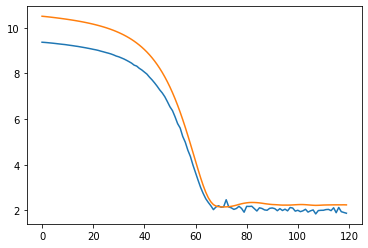

In [28]:
plt.plot(history.epoch,history.history['loss'])
plt.plot(history.epoch,history.history['val_loss'])

In [29]:
model.evaluate([x_test['user_id'],x_test['side_info_user'],x_test['battery_id'],x_test['side_info_item']],y_test) #loss,rmse,mae

122/122 [==============================] - 0s 41us/step


[1.8817953633480384, 2.297883987426758, 1.8791282176971436]

In [30]:
y_hat = model.predict([x_test['user_id'],x_test['side_info_user'],x_test['battery_id'],x_test['side_info_item']])

In [31]:
import numpy as np

In [32]:
y_true = np.array(y_test.rating)

# simple neural network

In [33]:
user_input = Input(shape=(1,),name='user_input', dtype='int32')
user_embedding = Embedding(151, latent_factors, name='user_embedding')(user_input)
user_flat = Flatten(name='user_flat')(user_embedding)
user_flat = Dropout(0.3)(user_flat)

In [34]:
movie_input = Input(shape=(1,),name='movie_input', dtype='int32')
movie_embedding = Embedding(40, latent_factors, name='movie_embedding')(movie_input)
movie_flat = Flatten(name='movie_flat')(movie_embedding)
movie_flat = Dropout(0.3)(movie_flat)

In [35]:
product = dot([user_flat, movie_flat], name='product', axes=1)

In [36]:
dense1 = Dense(512, activation='relu')(product)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(256, activation='relu')(dense1)
dense2 = Dropout(0.3)(dense2)
dense3 = Dense(128, activation='relu')(dense2)
dense3 = Dropout(0.3)(dense3)
dense4 = Dense(64, activation='relu')(dense3)
dense_out = Dense(1, activation='relu')(dense4)

In [37]:
model1 = Model([user_input, movie_input], dense_out)


In [38]:
learning_rate = 0.00005
epochs = 120
batch_size = 256

In [39]:
model1.compile(optimizer=Adam(lr=learning_rate), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [40]:
fit = model1.fit([x_train['user_id'], x_train['battery_id']], y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True, 
                validation_split=0.25)

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 364 samples, validate on 122 samples
Epoch 1/120
364/364 [==============================] - 0s 715us/step - loss: 9.3699 - root_mean_squared_error: 3.0707 - mean_absolute_error: 2.7741 - val_loss: 10.5090 - val_root_mean_squared_error: 3.1074 - val_mean_absolute_error: 2.7897
Epoch 2/120
364/364 [==============================] - 0s 38us/step - loss: 9.3628 - root_mean_squared_error: 3.0831 - mean_absolute_error: 2.7709 - val_loss: 10.5000 - val_root_mean_squared_error: 3.1068 - val_mean_absolute_error: 2.7890
Epoch 3/120
364/364 [==============================] - 0s 38us/step - loss: 9.3549 - root_mean_squared_error: 3.0938 - mean_absolute_error: 2.7797 - val_loss: 10.4901 - val_root_mean_squared_error: 3.1061 - val_mean_absolute_error: 2.7883
Epoch 4/120
364/364 [==============================] - 0s 36us/step - loss: 9.3461 - root_mean_squared_error: 3.0969 - mean_absolute_error: 2.7808 - val_loss: 10.4795 - val_root_mean_squared_error: 3.1054 - val_mean_absolute_error: 2.78

364/364 [==============================] - 0s 41us/step - loss: 8.7403 - root_mean_squared_error: 3.0675 - mean_absolute_error: 2.7455 - val_loss: 9.7613 - val_root_mean_squared_error: 3.0672 - val_mean_absolute_error: 2.7447
Epoch 36/120
364/364 [==============================] - 0s 36us/step - loss: 8.6868 - root_mean_squared_error: 3.0648 - mean_absolute_error: 2.7423 - val_loss: 9.7153 - val_root_mean_squared_error: 3.0651 - val_mean_absolute_error: 2.7423
Epoch 37/120
364/364 [==============================] - 0s 41us/step - loss: 8.6445 - root_mean_squared_error: 3.0630 - mean_absolute_error: 2.7403 - val_loss: 9.6667 - val_root_mean_squared_error: 3.0629 - val_mean_absolute_error: 2.7399
Epoch 38/120
364/364 [==============================] - 0s 38us/step - loss: 8.6029 - root_mean_squared_error: 3.0606 - mean_absolute_error: 2.7375 - val_loss: 9.6157 - val_root_mean_squared_error: 3.0607 - val_mean_absolute_error: 2.7373
Epoch 39/120
364/364 [==============================] - 0

Epoch 69/120
364/364 [==============================] - 0s 36us/step - loss: 5.7249 - root_mean_squared_error: 2.9303 - mean_absolute_error: 2.5821 - val_loss: 6.4275 - val_root_mean_squared_error: 2.9281 - val_mean_absolute_error: 2.5792
Epoch 70/120
364/364 [==============================] - 0s 38us/step - loss: 5.5501 - root_mean_squared_error: 2.9234 - mean_absolute_error: 2.5734 - val_loss: 6.2686 - val_root_mean_squared_error: 2.9212 - val_mean_absolute_error: 2.5705
Epoch 71/120
364/364 [==============================] - 0s 36us/step - loss: 5.3731 - root_mean_squared_error: 2.9163 - mean_absolute_error: 2.5645 - val_loss: 6.1076 - val_root_mean_squared_error: 2.9140 - val_mean_absolute_error: 2.5613
Epoch 72/120
364/364 [==============================] - 0s 36us/step - loss: 5.2941 - root_mean_squared_error: 2.9091 - mean_absolute_error: 2.5552 - val_loss: 5.9447 - val_root_mean_squared_error: 2.9068 - val_mean_absolute_error: 2.5521
Epoch 73/120
364/364 [======================

364/364 [==============================] - 0s 38us/step - loss: 1.9496 - root_mean_squared_error: 2.6288 - mean_absolute_error: 2.2215 - val_loss: 2.2605 - val_root_mean_squared_error: 2.6257 - val_mean_absolute_error: 2.2183
Epoch 104/120
364/364 [==============================] - 0s 36us/step - loss: 1.9827 - root_mean_squared_error: 2.6199 - mean_absolute_error: 2.2119 - val_loss: 2.2374 - val_root_mean_squared_error: 2.6168 - val_mean_absolute_error: 2.2086
Epoch 105/120
364/364 [==============================] - 0s 33us/step - loss: 1.9099 - root_mean_squared_error: 2.6111 - mean_absolute_error: 2.2024 - val_loss: 2.2187 - val_root_mean_squared_error: 2.6079 - val_mean_absolute_error: 2.1991
Epoch 106/120
364/364 [==============================] - 0s 36us/step - loss: 1.9080 - root_mean_squared_error: 2.6022 - mean_absolute_error: 2.1928 - val_loss: 2.2036 - val_root_mean_squared_error: 2.5992 - val_mean_absolute_error: 2.1896
Epoch 107/120
364/364 [==============================]

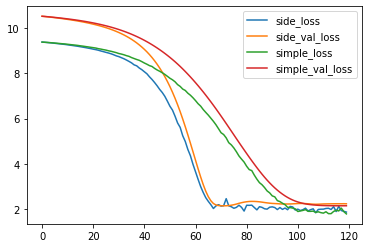

In [41]:
plt.plot(history.epoch,history.history['loss'],label='side_loss')
plt.plot(history.epoch,history.history['val_loss'],label='side_val_loss')
plt.plot(fit.epoch,fit.history['loss'],label='simple_loss')
plt.plot(fit.epoch,fit.history['val_loss'],label='simple_val_loss')
plt.legend()

In [42]:
model.evaluate([x_test['user_id'],x_test['side_info_user'],x_test['battery_id'],x_test['side_info_item']],y_test)
#loss,rmse,mae

122/122 [==============================] - 0s 49us/step


[1.8817953633480384, 2.296342134475708, 1.8775705099105835]

In [43]:
model1.evaluate([x_train['user_id'], x_train['battery_id']], y_train)

486/486 [==============================] - 0s 27us/step


[1.8713178276525113, 2.48502779006958, 2.06929612159729]